In [96]:
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
import numpy.random as npr 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [97]:

# Créez un ensemble de données avec 1000 échantillons, 20 caractéristiques et 3 classes pour la variable cible
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, n_classes=3, random_state=0)
# n_informative : nombre de caractéristiques informatives, celles qui sont réellement utiles pour prédire la classe cible.
# n_redundant : nombre de caractéristiques redondantes générées comme des combinaisons linéaires des caractéristiques informatives.

X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.2)

In [98]:
# Vérification que les groupes sont équilibrés :

for i in range(3):
    print(len(Y_train[Y_train==i])/len(Y_train))

0.33625
0.33375
0.33


In [99]:
#Premier modèle d'arbre sous certaines contraintes

clf = DecisionTreeClassifier(criterion='entropy',max_depth=10,ccp_alpha=0.03)

clf.fit(X_train, Y_train)

X_pred_train = clf.predict(X_train)
X_pred_test = clf.predict(X_test)

print('accuracy score train', accuracy_score(X_pred_train,Y_train))
print('accuracy score test', accuracy_score(X_pred_test,Y_test))


accuracy score train 0.67125
accuracy score test 0.575


In [111]:
def vote_majoritaire(matrice):
    modes = []
    for ligne in matrice:
        valeurs, compte = np.unique(ligne, return_counts=True)
        mode = valeurs[np.argmax(compte)]
        modes.append(mode)
    return np.array(modes).reshape((matrice.shape[0],1))


def boosting_tree_classifie(X_train,X_test,Y_train,Y_test,clf,it=10,display=True):
    models = {}
    n = len(Y_train)
    m = len(Y_test)
    Y_train = np.array(Y_train)
    Y_test = np.array(Y_test)
    Err_train = []
    Err_test = []
    W = np.ones(n)/n 
    
    #Initialisation:
    
    models[f'model{0}'] = clf.fit(X_train, Y_train,sample_weight=W)
    Y_pred_train = models[f'model{0}'].predict(X_train).reshape((n,1))
    Y_pred_test = models[f'model{0}'].predict(X_test).reshape((m,1))
    
    for k in range(1,it+1):
        models[f'model{k}'] = clf.fit(X_train, Y_train,sample_weight=W)

        Y_pred_train = np.hstack(( Y_pred_train,models[f'model{k}'].predict(X_train).reshape((n,1)) ) )
        Y_pred_test = np.hstack((Y_pred_test,models[f'model{k}'].predict(X_test).reshape((m,1)) ) )
            
        YY_pred_train = vote_majoritaire(Y_pred_train)
        YY_pred_test = vote_majoritaire(Y_pred_test)
        
        #Chargement de l'erreur de prédiction avec ce modèle Bootstrap
        Err_train.append(1-accuracy_score(YY_pred_train,Y_train))
        Err_test.append(1-accuracy_score(YY_pred_test,Y_test))
        
        #Chargement des poids et attribution des des nouveaux poids
        if k<it:
            P = models[f'model{k}'].predict_proba(X_train)
            for i in range(n):
                W[i] = 1 - P[i,Y_train[i]]
    if display:
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.plot(1-np.array(Err_train),label='train')
        plt.plot(1-np.array(Err_test),label='test')
        plt.title(f'Acurracy score pour {it} ittérations \n dans la méthode du boosting')
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(Err_train,label='train')
        plt.plot(Err_test,label='test')
        plt.title(f'Erreur pour {it} ittérations \n dans la méthode du boosting')
        plt.legend()
        plt.show()
        
 

### Avec différents types d'arbres

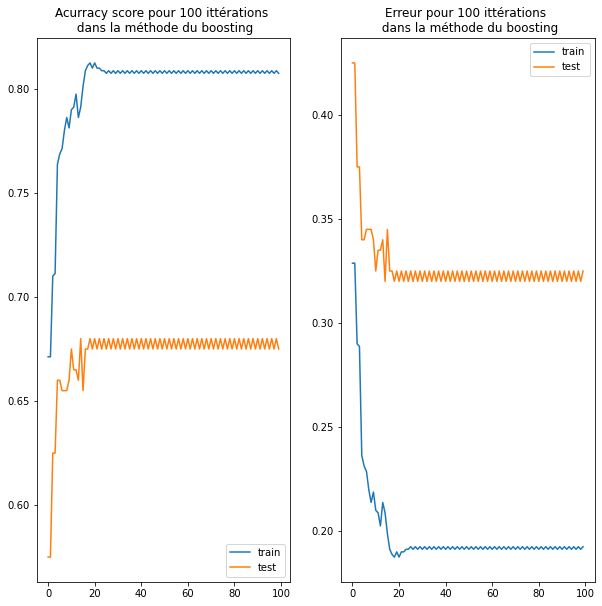

In [112]:
clf = DecisionTreeClassifier(criterion='entropy',max_depth=10,ccp_alpha=0.03)

boosting_tree_classifie(X_train,X_test,Y_train,Y_test,clf,it=100,display=True)  

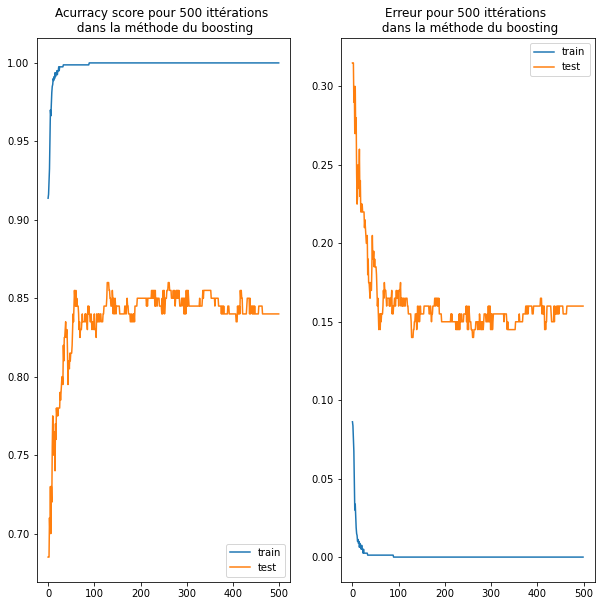

In [113]:
clf = DecisionTreeClassifier(criterion='gini',max_depth=7)

boosting_tree_classifie(X_train,X_test,Y_train,Y_test,clf,it=500,display=True) 

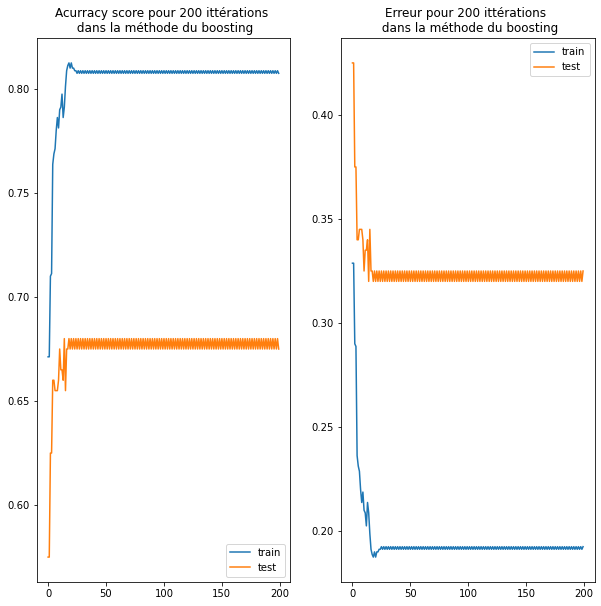

In [114]:
clf = DecisionTreeClassifier(criterion='entropy',ccp_alpha=0.03)

boosting_tree_classifie(X_train,X_test,Y_train,Y_test,clf,it=200,display=True) 

# Avec le jeu de données spam7.csv

In [115]:
path = '/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/TP2/spam7.csv'
df = pd.read_csv(path, sep=';')

#Attribution 0,1
df['yesno'] = df['yesno'].map({'y':1,'n':0})

X = df.drop(columns='yesno',axis=1)
Y = df['yesno']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

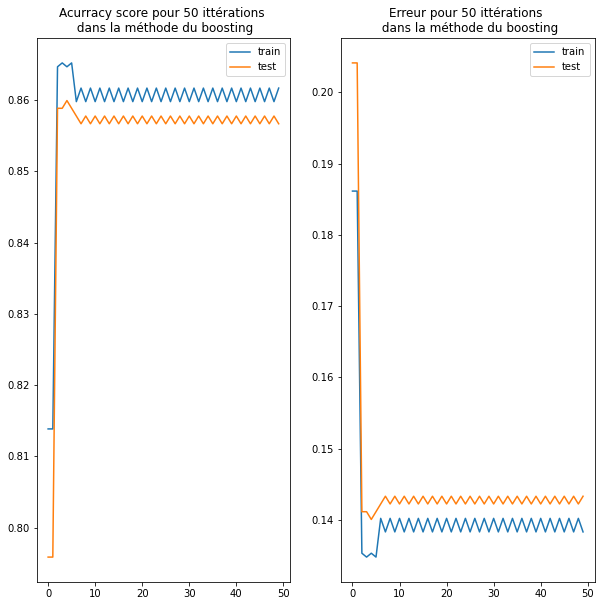

In [116]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=15)

boosting_tree_classifie(X_train,X_test,Y_train,Y_test,clf,it=50,display=True)
